**1. Linear Regression**

Download the datasets Dataset 1 (README). 

Perform Linear Regression on the given dataset. Also perform K-Fold cross-validation in this exercise.

**Analysis to be included in your report:**

(a) Choose an appropriate value of K and justify it in your report along with the preprocessing strategy.

(b) Include plots between training loss v/s iterations and validation loss v/s iterations.

(c) Implement gradient descent using two losses - RMSE loss and MAE loss. Include the best RMSE and MAE value achieved in your report. 

**Preparations and EDA**

Importing data science packages and checking what files there are in the dataset

In [50]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

Setting visualisation parameters

In [51]:
# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

# Matplotlib visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")

# Set default font size and facecolor
plt.rcParams["font.size"] = 24
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize
figsize(15, 12)

# Seaborn for visualization
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


Reading and exploring data

In [52]:
data = pd.read_csv("/content/Video_Games_Sales_as_at_22_Dec_2016.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


There are ~17k games, but some of the data is missing. For instance, only around half of all games has a critic score. This might be a problem for the prediction model, as I was thinking that critic score will be one of the main features. But I will come back to it later. Another issue is that the User_Score column has type object instead of float (like Critic_Score). It means that there are non-numeric values and I'll have to get rid of them.

Here I am doing 3 things:

1. Renaming columns for ease of use
2. Droping games without a year of release or genre
3. Creating a new column for age of the game

In [53]:
data = data.rename(columns={"Year_of_Release": "Year", 
                            "NA_Sales": "NA",
                            "EU_Sales": "EU",
                            "JP_Sales": "JP",
                            "Other_Sales": "Other",
                            "Global_Sales": "Global"})
data = data[data["Year"].notnull()]
data = data[data["Genre"].notnull()]
data["Year"] = data["Year"].apply(int)
data["Age"] = 2018 - data["Year"]
data.describe(include="all")

,Name,Platform,Year,Genre,Publisher,NA,EU,JP,Other,Global,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Age
count,16448,16448,16448.000000,16448,16416,16448.000000,16448.000000,16448.000000,16448.000000,16448.00000,7983.000000,7983.000000,9840,7463.000000,9907,9769,16448.000000
unique,11429,31,NaN,12,578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96,NaN,1680,8,NaN
top,Need for Speed: Most Wanted,PS2,NaN,Action,Electronic Arts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tbd,NaN,Ubisoft,E,NaN
freq,12,2127,NaN,3308,1344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2377,NaN,201,3922,NaN
mean,NaN,NaN,2006.488996,NaN,NaN,0.263965,0.145895,0.078472,0.047583,0.53617,68.994363,26.441313,NaN,163.015141,NaN,NaN,11.511004
std,NaN,NaN,5.877470,NaN,NaN,0.818286,0.506660,0.311064,0.187984,1.55846,13.920060,19.008136,NaN,563.863327,NaN,NaN,5.877470
min,NaN,NaN,1980.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.01000,13.000000,3.000000,NaN,4.000000,NaN,NaN,-2.000000
25%,NaN,NaN,2003.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.06000,60.000000,12.000000,NaN,10.000000,NaN,NaN,8.000000
50%,NaN,NaN,2007.000000,NaN,NaN,0.080000,0.020000,0.000000,0.010000,0.17000,71.000000,22.000000,NaN,24.000000,NaN,NaN,11.000000
75%,NaN,NaN,2010.000000,NaN,NaN,0.240000,0.110000,0.040000,0.030000,0.47000,79.000000,36.000000,NaN,81.000000,NaN,NaN,15.000000


2 things to see in the table above:

1. The top value in User_Score column is "tbd" which I will mark as NaN.
2. There are serious outliers in sales columns (Global, EU, NA, JP, Other) and User_Count column.

In [27]:
# Replacing "tbd" values with np.nan and transforming column to float type
data["User_Score"] = data["User_Score"].replace("tbd", np.nan).astype(float)

Next I want to see how many values there are missing in each column.

In [54]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : "Missing Values", 1 : "% of Total Values"})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        "% of Total Values", ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [55]:
missing_values_table(data)

Your selected dataframe has 17 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
User_Count,8985,54.6
Critic_Score,8465,51.5
Critic_Count,8465,51.5
Rating,6679,40.6
User_Score,6608,40.2
Developer,6541,39.8
Publisher,32,0.2


More than 50% of user and critic scores are missing. Usually I drop features with too many missing values, but here I think that scores are invaluable for sales prediction, so I'll have to find a way around the problem.

As I mentioned above, there are outliers in sales columns. They might be usefull for training as they indicate bestseller games, but for now I am going to remove them.

Here an outlier is defined as a value greater than (or lesser than) third quartile (first quartile) plus 3 interquartile ranges (minus 3 interqurtile ranges).

In [56]:
def rm_outliers(df, list_of_keys):
    df_out = df
    for key in list_of_keys:
        # Calculate first and third quartile
        first_quartile = df_out[key].describe()["25%"]
        third_quartile = df_out[key].describe()["75%"]

        # Interquartile range
        iqr = third_quartile - first_quartile

        # Remove outliers
        removed = df_out[(df_out[key] <= (first_quartile - 3 * iqr)) |
                    (df_out[key] >= (third_quartile + 3 * iqr))] 
        df_out = df_out[(df_out[key] > (first_quartile - 3 * iqr)) &
                    (df_out[key] < (third_quartile + 3 * iqr))]
    return df_out, removed

In [57]:
data, rmvd_global = rm_outliers(data, ["Global"])
data.describe()

,Year,NA,EU,JP,Other,Global,Critic_Score,Critic_Count,User_Count,Age
count,15401.000000,15401.000000,15401.000000,15401.000000,15401.000000,15401.000000,7286.000000,7286.000000,6747.000000,15401.000000
mean,2006.592624,0.144688,0.072628,0.047301,0.024357,0.289258,67.779028,24.518117,111.325033,11.407376
std,5.758078,0.210709,0.131408,0.130786,0.050152,0.346918,13.612120,17.194878,406.635191,5.758078
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,4.000000,-2.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,59.000000,11.000000,9.000000,8.000000
50%,2007.000000,0.070000,0.020000,0.000000,0.010000,0.150000,70.000000,20.000000,21.000000,11.000000
75%,2010.000000,0.190000,0.080000,0.030000,0.030000,0.380000,78.000000,34.000000,61.000000,15.000000
max,2020.000000,1.670000,1.580000,1.650000,1.180000,1.690000,98.000000,106.000000,10665.000000,38.000000


In [58]:
data["Has_Score"] = data["User_Score"].notnull() & data["Critic_Score"].notnull()
rmvd_global["Has_Score"] = rmvd_global["User_Score"].notnull() & rmvd_global["Critic_Score"].notnull()

**Basic model**

For my basic model I am going to drop games that don't have a user score, critic score or rating.

In [59]:
scored = data.dropna(subset=["User_Score", "Critic_Score", "Rating"])
scored.describe()

,Year,NA,EU,JP,Other,Global,Critic_Score,Critic_Count,User_Count,Age
count,7185.000000,7185.000000,7185.000000,7185.000000,7185.000000,7185.000000,7185.000000,7185.000000,6137.000000,7185.000000
mean,2007.121364,0.195992,0.102938,0.025637,0.035795,0.360692,67.776061,24.617676,118.897181,10.878636
std,4.115742,0.223204,0.149407,0.088654,0.058430,0.378126,13.614107,17.231793,424.446207,4.115742
min,1985.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,4.000000,2.000000
25%,2004.000000,0.050000,0.010000,0.000000,0.010000,0.090000,59.000000,11.000000,10.000000,8.000000
50%,2007.000000,0.110000,0.040000,0.000000,0.020000,0.210000,70.000000,20.000000,23.000000,11.000000
75%,2010.000000,0.260000,0.130000,0.000000,0.040000,0.510000,78.000000,34.000000,66.000000,14.000000
max,2016.000000,1.670000,1.580000,1.390000,1.180000,1.690000,98.000000,106.000000,10665.000000,33.000000


I will also remove outliers in User_Count column.

In [60]:
scored, rmvd_user_count = rm_outliers(scored, ["User_Count"])
scored.describe()

,Year,NA,EU,JP,Other,Global,Critic_Score,Critic_Count,User_Count,Age
count,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000
mean,2007.055837,0.205403,0.098572,0.028995,0.036368,0.369597,67.815866,24.958439,37.459523,10.944163
std,4.010373,0.225580,0.138941,0.095492,0.056428,0.367824,13.408831,15.689528,44.572477,4.010373
min,1985.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,4.000000,2.000000
25%,2004.000000,0.060000,0.010000,0.000000,0.010000,0.100000,60.000000,13.000000,9.000000,8.000000
50%,2007.000000,0.130000,0.040000,0.000000,0.020000,0.230000,70.000000,22.000000,20.000000,11.000000
75%,2010.000000,0.280000,0.130000,0.000000,0.047500,0.520000,78.000000,34.000000,45.000000,14.000000
max,2016.000000,1.670000,1.160000,1.390000,1.130000,1.690000,98.000000,91.000000,233.000000,33.000000


Only 5.5k games, ~1/3 of all games in a dataset. That for a basic model it will be ok.

In [61]:
pip install category_encoders

In [62]:
import category_encoders as ce
# Select the numeric columns
numeric_subset = scored.select_dtypes("number").drop(columns=["NA", "EU", "JP", "Other", "Year"])

# Select the categorical column
categorical_subset = scored[["Platform", "Genre", "Rating"]]

# One hot encode
encoder = ce.one_hot.OneHotEncoder()
categorical_subset = encoder.fit_transform(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

# Find correlations with the score 
correlations = features.corr()["Global"].dropna().sort_values()

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Splitting data into train and test sets.

In [63]:
from sklearn.model_selection import train_test_split
X = pd.Series(features["Global"]).values.reshape(-1,1)
y = features.drop(columns="Global")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4427, 1)
(1107, 1)
(4427, 38)
(1107, 38)


Defining a function to evaluate my model. I will use mean absolute error.

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [43]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)

crossvalidation = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(linreg, X, y, scoring="neg_mean_squared_error", cv=crossvalidation, n_jobs=1)
mae = scores.mean()
rmse = np.sqrt(-scores)

print("\nLinear Regression Performance on the test set: RMSE (Root Mean Squared Error) : {:.4f} \n".format(rmse.mean()))
print("Linear Regression Performance on the test set: MAE (Mean Absolute Error) : %.3f" %(mae))


Linear Regression Performance on the test set: RMSE (Root Mean Squared Error) : 7.6311 

Linear Regression Performance on the test set: MAE (Mean Absolute Error) : -58.267


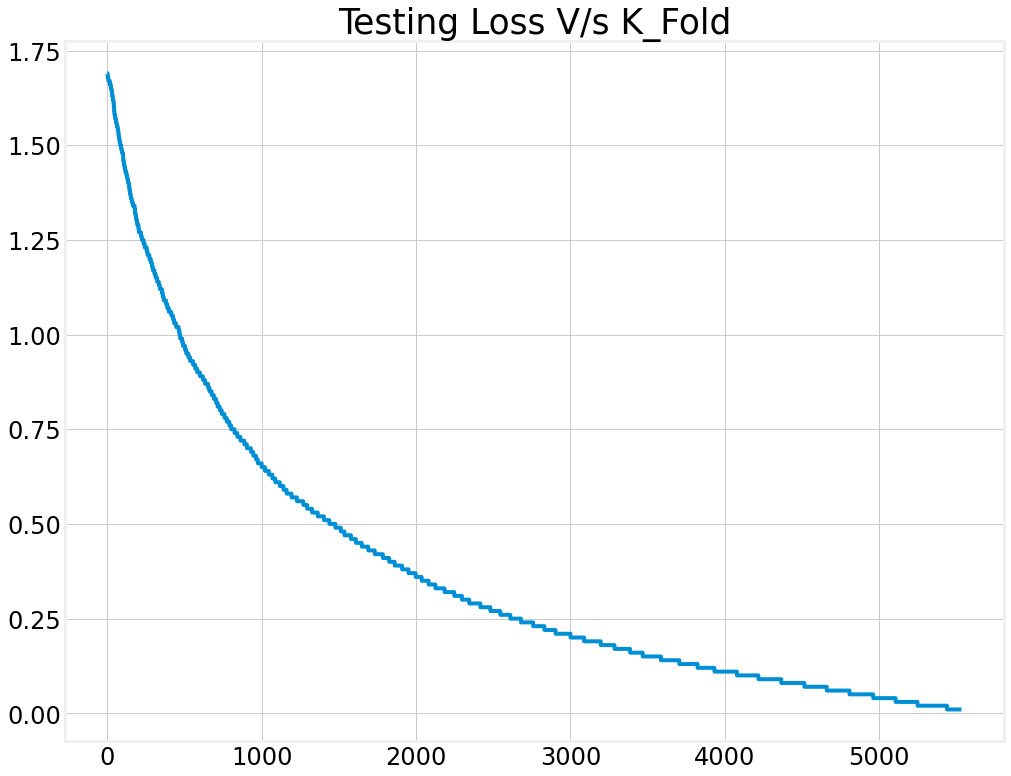

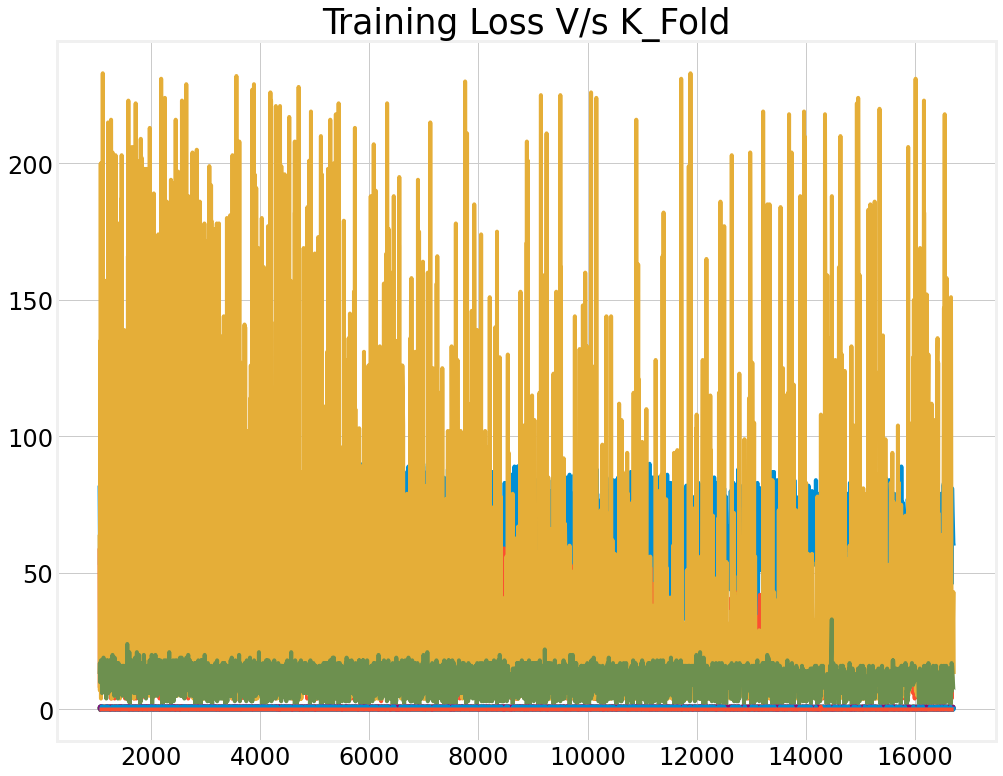

In [65]:
print('\n')
# Validation Loss in K Fold
plt.title('Testing Loss V/s K_Fold')
plt.plot(X) 
plt.show()

print('\n') 
# Training Loss in K Fold
plt.title('Training Loss V/s K_Fold')
plt.plot(y) 
plt.show()

In [49]:
def gradient_descent(X, y, lr=0.05, epoch=10):
    
    m, b = 0.2, 0.2 # parameters
    log, mse = [], [] # lists to store learning process
    N = len(X) # number of samples
    
    for _ in range(epoch):
                
        f = y - (m*X + b)
    
        # Updating m and b
        m -= lr * (-2 * X.dot(f).sum() / N)
        b -= lr * (-2 * f.sum() / N)
        
        log.append((m, b))
        mse.append(mean_squared_error(y, (m*X + b)))        
    
    return m, b, log, mse

In [19]:
X = features.Global
y = features.Global

m, b, log, mse = gradient_descent(X, y, lr=0.01, epoch=100)

y_pred = m*X + b

print("MSE:",mean_squared_error(y, y_pred))
print("RMSE:",np.sqrt(mean_squared_error(y, y_pred)))

MSE: 0.04886232142764541
RMSE: 0.22104823326062892


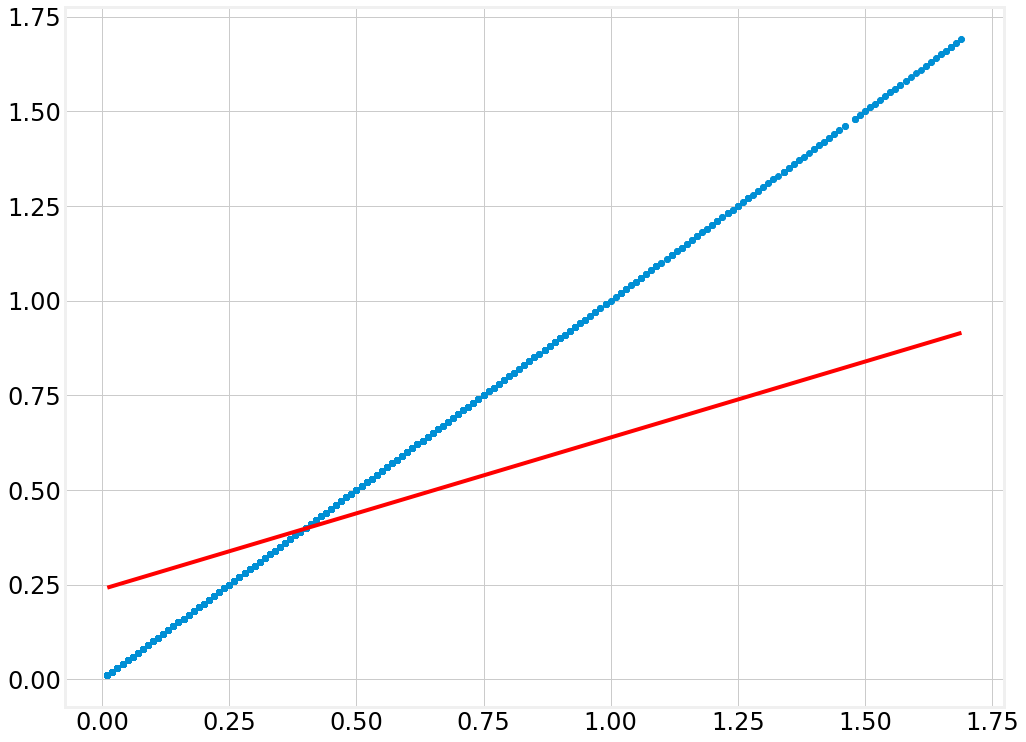

In [ ]:
plt.scatter(X, y) 
plt.plot([min(X), max(X)], [min(y_pred), max(y_pred)], color='red')  # regression line
plt.show()